In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy.linalg as LA
import pandas as pd

In [2]:
import Function as f

In [3]:
max_iteration = 10000
weight_decay = 1e-5
NUM_EMPLOYEES = 2000
NUM_TRAIN = 1800
NUM_VAL = 200
Epsilons = [10, 10]
NUM_FEATURES = 10
BANDWIDTH = 1.2

In [4]:
np.random.seed(NUM_EMPLOYEES)

In [5]:
X, Y, survival_times = f.Generating_Synthetic_Set(NUM_EMPLOYEES, NUM_FEATURES, Epsilons)

In [6]:
five_percent = int(len(survival_times) * 0.05)
five_percent_indices = np.argsort(survival_times)[(-1) * five_percent:]
threshold_age = survival_times[five_percent_indices[0]]
for i in five_percent_indices:
    while(True):
        Epsilon_1, Epsilon_2 = Epsilons
        _lambda = Epsilon_1 * np.sum(X[i, :] ** 2) + Epsilon_2 * np.sum(X[i, :])
        age = np.ceil(np.random.exponential(_lambda, size=1))
        if age <= threshold_age:
            survival_times[i] = age
            break
NUM_TASKS = int(np.max(survival_times))
Y = np.ones((NUM_EMPLOYEES, NUM_TASKS))
# the lifetime matrix of all employees, if one employee leave at the time interval k, then from Y[i,k](inlcude)  all entries are -1
for i in range(NUM_EMPLOYEES):
    Y[i, int(survival_times[i]):] = -1

In [7]:
X_train = X[:NUM_TRAIN]
X_val = X[NUM_TRAIN:]
Y_train = Y[:NUM_TRAIN]
Y_val = Y[NUM_TRAIN:]

In [8]:
Kernel_Matrix = f.Generating_Kernel(X, "Gaussian_Kernel", BW = BANDWIDTH)
# Kernel_Matrix = f.Generating_Kernel(X, "Quick_Gaussian_Kernel", BW = BANDWIDTH)
# Kernel_Matrix = f.Generating_Kernel(X, "Linear_Kernel", BW = BANDWIDTH)
Kernel_Matrix_Train = Kernel_Matrix[:NUM_TRAIN,:NUM_TRAIN]
Kernel_Matrix_Val = Kernel_Matrix[NUM_TRAIN:,:NUM_TRAIN]

There are  3895616 pairs of samples of similarity between 0.0 and 0.1 which have an average age_gap  82.04893141418457 and the median is: 59.0
There are  77264 pairs of samples of similarity between 0.1 and 0.2 which have an average age_gap  62.384603437564714 and the median is: 39.0
There are  17762 pairs of samples of similarity between 0.2 and 0.3 which have an average age_gap  59.29703862177683 and the median is: 37.0
There are  5142 pairs of samples of similarity between 0.3 and 0.4 which have an average age_gap  57.67172306495527 and the median is: 35.0
There are  1588 pairs of samples of similarity between 0.4 and 0.5 which have an average age_gap  53.340050377833755 and the median is: 33.0
There are  468 pairs of samples of similarity between 0.5 and 0.6 which have an average age_gap  53.324786324786324 and the median is: 28.5
There are  136 pairs of samples of similarity between 0.6 and 0.7 which have an average age_gap  44.23529411764706 and the median is: 27.0
There are  22 

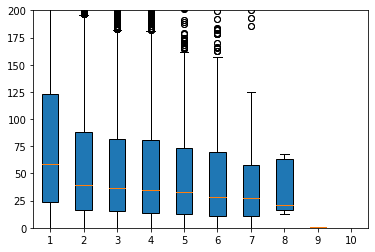

In [9]:
f.Validate_Synthetic_DataSet(Kernel_Matrix, survival_times)

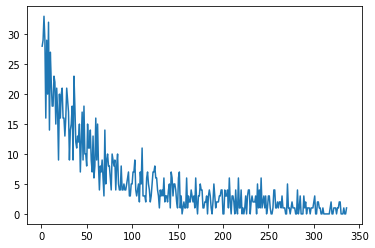

In [10]:
NUM_TASKS = Y.shape[1]
x_axis = np.arange(NUM_TASKS)+1
y_train_gt_axis = np.zeros(NUM_TASKS)
for i in range(NUM_TASKS):
    y_train_gt_axis[i] = np.sum(survival_times[:NUM_TRAIN] == x_axis[i])
plt.plot(x_axis, y_train_gt_axis)

In [11]:
print(NUM_TASKS)
## DEL TOP 5%

336


In [ ]:
alpha = np.zeros_like(Y_train) 
# alpha = np.ones_like(Y_train) 
predict_age = np.zeros(NUM_EMPLOYEES) 
val_loss_list = []
index = 0
for t in range(1, max_iteration+1):

    alpha = f.Kernel_Pegasos(180, Kernel_Matrix_Train, alpha, Y_train, t, weight_decay)
    # alpha = f.Split_Kernel_Pegasos(1, Kernel_Matrix_Train, alpha, Y_train, t, weight_decay) 
    
    if t%500 == 0 or t == 1: 
        print("the iteration is:", t)
        hatY_train = Kernel_Matrix_Train.dot(alpha*Y_train) / ( t * weight_decay )
        
        hatY_val =  Kernel_Matrix_Val.dot(alpha*Y_train) / ( t * weight_decay )
        
        # predict_age_tr = f.Ages(hatY_train)
        # predict_age_val = f.Ages(hatY_val)
        predict_age_tr = f.Weighted_Ages(hatY_train)
        predict_age_val = f.Weighted_Ages(hatY_val)
        # predict_age_tr = f.new_ages(hatY_train)
        # predict_age_val = f.new_ages(hatY_val)
        predict_age = predict_age_tr + predict_age_val
            
        acc_train = np.sum(Y_train * hatY_train > 0) / (NUM_TRAIN * NUM_TASKS)
        acc_val = np.sum(Y_val * hatY_val > 0) / (NUM_VAL * NUM_TASKS)
        print("the train accuracy is:", acc_train)
        print("the val accuracy is:", acc_val)
        
        # C_index_tr = f.Calculate_C_index(survival_times[:NUM_TRAIN], predict_age_tr)
        C_index_val = f.Calculate_C_index(survival_times[NUM_TRAIN:], predict_age_val)
         
            
        # print("the c-index for training is:", C_index_tr)xx
        print("the c-index for val is:", C_index_val)
  
print(np.sum(predict_age[NUM_TRAIN:] == survival_times[NUM_TRAIN:])/(NUM_VAL))

the iteration is: 1
the train accuracy is: 0.0
the val accuracy is: 0.0


/Users/menglvshi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/menglvshi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 19777.0
the c-index for val is: 0.0


In [ ]:
x_axis = np.arange(NUM_TASKS)+1 # the x axis
y_train_gt_axis = np.zeros(NUM_TASKS) # the ground truth train axis
y_val_gt_axis = np.zeros(NUM_TASKS) # the groud truth validation axis 
y_train_predict_axis = np.zeros(NUM_TASKS) # the predict train axis 
y_val_predict_axis = np.zeros(NUM_TASKS) # the predict validation axis 

for i in range(NUM_TASKS):
    y_train_gt_axis[i] = np.sum(survival_times[:NUM_TRAIN] == x_axis[i])
    y_val_gt_axis[i] = np.sum(survival_times[NUM_TRAIN:] == x_axis[i])
    y_train_predict_axis[i] = np.sum(predict_age[:NUM_TRAIN] == x_axis[i])
    y_val_predict_axis[i] = np.sum(predict_age[NUM_TRAIN:] == x_axis[i])
# plt.plot(x_axis, y_train_gt_axis, x_axis, y_train_predict_axis) # the training set: ground truth vs predict situation
# plt.plot(x_axis, y_val_gt_axis, x_axis, y_val_predict_axis) # the valiadtion set: ground truth vs predictsituation
plt.subplot(211)
plt.plot(x_axis, y_val_gt_axis)
plt.subplot(212)
plt.plot(x_axis, y_val_predict_axis)
# plt.plot(x_axis,y_train_predict_axis,y_val_predict_axis)

# 